### Create placeholders

In [122]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0], name = "x_in")
    Y = tf.placeholder(tf.float32, shape=[None, n_y], name = "y_in")
    return X, Y

### Initialize parameters

In [142]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow.
    
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    layer_depth = {
        'conv1': 6,
        'conv2': 16,
        'fc1': 120,
        'fc2': 84,
        'fc3': n_classes
    }

    filter_size={
        'conv_1': 5
        ,'conv_2': 5
    }
    
    tf.set_random_seed(1)                             

    weights = {
        'conv1': tf.get_variable(name="conv1w", shape=[filter_size['conv_1'], filter_size['conv_1'], 3, layer_depth['conv1']], initializer=tf.contrib.layers.xavier_initializer(seed = 0)),
        'conv2': tf.get_variable(name="conv2w", shape=[filter_size['conv_2'], filter_size['conv_2'], layer_depth['conv1'], layer_depth['conv2']], initializer=tf.contrib.layers.xavier_initializer(seed = 0)),
        'fc1':  tf.get_variable(name="fc1w", shape=[1024, layer_depth['fc1']], initializer=tf.contrib.layers.xavier_initializer(seed = 0)),
        'fc2':  tf.get_variable(name="fc2w", shape=[layer_depth['fc1'], layer_depth['fc2']], initializer=tf.contrib.layers.xavier_initializer(seed = 0)),
        'fc3':  tf.get_variable(name="fc3w", shape=[layer_depth['fc2'], layer_depth['fc3']], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    }

    biases = {
        'conv1': tf.get_variable(name="conv1b", shape=[layer_depth['conv1']], initializer=tf.contrib.layers.xavier_initializer(seed = 0)),
        'conv2': tf.get_variable(name="conv2b", shape=[layer_depth['conv2']], initializer=tf.contrib.layers.xavier_initializer(seed = 0)),
        'fc1': tf.get_variable(name="fc1b", shape=[layer_depth['fc1']], initializer=tf.contrib.layers.xavier_initializer(seed = 0)),
        'fc2': tf.get_variable(name="fc2b", shape=[layer_depth['fc2']], initializer=tf.contrib.layers.xavier_initializer(seed = 0)),
        'fc3': tf.get_variable(name="fc3b", shape=[layer_depth['fc3']], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    }
    
    
    parameters = {"weights": weights,
                  "biases": biases}
    
    return parameters

### Forward propagation

In **TensorFlow**, there are built-in functions that carry out the convolution steps.

`tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME')`: given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev).

`tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')`: given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.

`tf.nn.relu(Z1)`: computes the elementwise ReLU of Z1 (which can be any shape).

`tf.contrib.layers.flatten(P)`: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k].

`tf.contrib.layers.fully_connected(F, num_outputs)`: given a the flattened input F, it returns the output computed using a fully connected layer.

In [148]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    weights = parameters['weights']
    biases = parameters['biases']

    stride = {
        'conv_1': 1
        ,'conv_2': 1
        ,'maxpool_1': 2
        ,'maxpool_2': 2
    }
    
    kernel_size={
        'maxpool_1': 2
        ,'maxpool_2': 2
    }
    
    # CONV2D: stride of 1, padding 'SAME'
    # tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
    Z1 = tf.nn.conv2d(X,weights["conv1"], strides = [1,stride["conv_1"],stride["conv_1"],1]
                      , padding = 'SAME'
                      , name="Conv_1")
    # RELU
    A1 = tf.nn.relu(Z1, name="Relu_1")
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,kernel_size["maxpool_1"],kernel_size["maxpool_1"],1]
                        , strides = [1,stride["maxpool_1"],stride["maxpool_1"],1]
                        , padding = 'SAME'
                        , name="Maxpool_1")
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,weights["conv2"]
                      , strides = [1,stride["conv_2"],stride["conv_2"],1]
                      , padding = 'SAME'
                      , name="Conv_2")
    # RELU
    A2 = tf.nn.relu(Z2, name="Relu_2")
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,kernel_size["maxpool_2"],kernel_size["maxpool_2"],1]
                        , strides= [1,stride["maxpool_2"],stride["maxpool_2"],1]
                        , padding = 'SAME'
                        , name="Maxpool_2")
    # FLATTEN
    FLAT_2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 43 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    FC3 = tf.nn.xw_plus_b(FLAT_2, weights['fc1'], biases['fc1'], name="FC_1")
    Z3 = tf.nn.relu(FC3, name="Relu_3")
    # FULLY-CONNECTED
    FC4 = tf.nn.xw_plus_b(FC3, weights['fc2'], biases['fc2'], name="FC_2")
    Z4 = tf.nn.relu(FC4, name="Relu_4")
    # FULLY-CONNECTED
    FC5 = tf.nn.xw_plus_b(FC4, weights['fc3'], biases['fc3'], name="FC_3")
    
    print (A1)
    print (P1)
    print (A2)
    print (P2)
    print (FLAT_2)
    print (FC3)
    print (Z3)
    print (FC4)
    print (Z4)
    print (FC5)
    
#     Z3 = tf.contrib.layers.fully_connected(P2, 43, activation_fn=None)

    return FC5

In [149]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(32, 32, 3, 4)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,32,32,3), Y: np.random.randn(2,4)})
    print (Z3.get_shape()[1])
#     print("Z3 = " + str(a))

Tensor("Relu_1:0", shape=(?, 32, 32, 6), dtype=float32)
Tensor("Maxpool_1:0", shape=(?, 16, 16, 6), dtype=float32)
Tensor("Relu_2:0", shape=(?, 16, 16, 16), dtype=float32)
Tensor("Maxpool_2:0", shape=(?, 8, 8, 16), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(?, 1024), dtype=float32)
Tensor("FC_1:0", shape=(?, 120), dtype=float32)
Tensor("Relu_3:0", shape=(?, 120), dtype=float32)
Tensor("FC_2:0", shape=(?, 84), dtype=float32)
Tensor("Relu_4:0", shape=(?, 84), dtype=float32)
Tensor("FC_3:0", shape=(?, 43), dtype=float32)
43


## Compute cost

In [150]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cross_ent = tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y, name="cross_entropy")
    cost = tf.reduce_mean(cross_ent, name="cost")
    
    return cost

In [151]:
def evaluate_with_batch(X_data, y_data, batch_size=64):
    """
    Creates a list of minibatches from (X, Y) for evaluation
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    batch_size -- size of the mini-batches, integer
    
    Returns:
    accuracy -- accuracy of model
    """
    mini_batches = []
    m = len(X_data)
    num_complete_minibatches = math.ceil(m/batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X, mini_batch_Y = X_data[k * batch_size:(k + 1) * batch_size], y_data[k * batch_size:(k + 1) * batch_size]
        mini_batch = [mini_batch_X, mini_batch_Y]
        mini_batches.append(mini_batch)
    return mini_batches    

In [152]:
from tensorflow.python.framework import ops

In [153]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 1, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    training_accuracies = []
    validation_accuracies = []
    
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z5 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z5, Y)

    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Z5, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            print ("epoch: "+str(epoch))
            
            for i,(minibatch_X, minibatch_Y) in enumerate(minibatches,1):
#                 print ("batch: "+str(i)+"/"+str(len(minibatches)))
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
            # Do the evaluation loop
            print ("evaluation start")
            minibatch_test = evaluate_with_batch(X_test, Y_test)
            minibatch_train = evaluate_with_batch(X_train, Y_train)

            train_accuracy = 0.0
            test_accuracy = 0.0

            for i,(minibatch_X, minibatch_Y) in enumerate(minibatch_train, 1):
    #             print ("batch: "+str(i)+"/"+str(len(minibatch_train)))
                train_accuracy += accuracy.eval({X: minibatch_X, Y: minibatch_Y})

            for i,(minibatch_X, minibatch_Y) in enumerate(minibatch_test, 1):
    #             print ("batch: "+str(i)+"/"+str(len(minibatch_test)))
                test_accuracy += accuracy.eval({X: minibatch_X, Y: minibatch_Y})
            
            print (train_accuracy/len(X_train))
            print (test_accuracy/len(X_test))
            training_accuracies.append(train_accuracy/len(X_train))
            validation_accuracies.append(test_accuracy/len(X_test))
            
            print ("evaluation ends")
            
        print("Train Accuracy:", training_accuracies)
        print("Test Accuracy:", validation_accuracies)    

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        save_path = saver.save(sess, os.path.join("model", "true_Lenet","fake_Lenet.ckpt"))
        print("Model saved in path: %s" % save_path)
        
        return training_accuracies, validation_accuracies

Tensor("Relu_1:0", shape=(?, 32, 32, 6), dtype=float32)
Tensor("Maxpool_1:0", shape=(?, 16, 16, 6), dtype=float32)
Tensor("Relu_2:0", shape=(?, 16, 16, 16), dtype=float32)
Tensor("Maxpool_2:0", shape=(?, 8, 8, 16), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(?, 1024), dtype=float32)
Tensor("FC_1:0", shape=(?, 120), dtype=float32)
Tensor("Relu_3:0", shape=(?, 120), dtype=float32)
Tensor("FC_2:0", shape=(?, 84), dtype=float32)
Tensor("Relu_4:0", shape=(?, 84), dtype=float32)
Tensor("FC_3:0", shape=(?, 43), dtype=float32)
epoch: 0
Cost after epoch 0: 1.250390
evaluation start
0.0138262845169
0.0126130121635
evaluation ends
epoch: 1
evaluation start
0.0146079208787
0.0131359224687
evaluation ends
epoch: 2
evaluation start
0.0151055830164
0.0136185149352
evaluation ends
epoch: 3
evaluation start
0.0153299198117
0.013838919193
evaluation ends
epoch: 4
evaluation start
0.0152729322491
0.0137166217071
evaluation ends
epoch: 5
Cost after epoch 5: 0.087421
evaluation start
0.015354

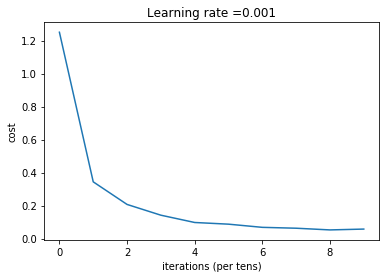

Model saved in path: model\true_Lenet\fake_Lenet.ckpt


In [154]:
train_accuracy, test_accuracy = model(X_train_norm, labels_train, X_valid_norm, labels_valid, num_epochs = )

Even though there is no file named model.ckpt, you still refer to the saved checkpoint by that name when restoring it. 
* `.meta` stores the graph structure. 
* `.data` stores the values of each variable in the graph. 
* `.index` identifies the checkpiont. 
So in the example above: import_meta_graph uses the .meta, and saver.restore uses the .data and .index

In [173]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(os.path.join("model", "true_Lenet","fake_Lenet.ckpt.meta"))
    saver.restore(sess, os.path.join("model", "true_Lenet","fake_Lenet.ckpt"))
    g = tf.get_default_graph()
#     for i in g.get_operations():
#         print (i.name)

    learning_rate = 0.0001
    cost = g.get_operation_by_name("cost")
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    for epoch_i in range(1):

        minibatch_test = evaluate_with_batch(X_valid_norm, labels_valid)
        test_accuracy = 0.0

        for i,(minibatch_X, minibatch_Y) in enumerate(minibatch_test, 1):
            _, curr_cost = sess.run([optimizer, cost], feed_dict={x_in: batch})
            
            test_accuracy += accuracy.eval({X: minibatch_X, Y: minibatch_Y})
        
    save_path = tf.train.Saver().save(sess, os.path.join("model", "true_Lenet","fake_Lenet.ckpt"))    


INFO:tensorflow:Restoring parameters from model\true_Lenet\fake_Lenet.ckpt


AttributeError: 'Operation' object has no attribute 'dtype'

In [140]:
def resume_model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001, num_epochs = 1, minibatch_size = 64, print_cost = True):

    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    training_accuracies = []
    validation_accuracies = []
    

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(os.path.join("model", "true_Lenet","fake_Lenet.ckpt.meta"))
        saver.restore(sess, os.path.join("model", "true_Lenet","fake_Lenet.ckpt"))
        
        
        g = tf.get_default_graph()
        x_in = g.get_tensor_by_name("x_in:0")
        cost = g.get_tensor_by_name("cost:0")

#         # Run the initialization
#         sess.run(init)

#         m = len(X_train)
#         minibatch_size = 64
#         num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
#         num_epochs = 10
#         seed = 0
#         # Do the training loop
#         for epoch in range(num_epochs):

#             minibatch_cost = 0.
#             seed = seed + 1
#             minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
#             print ("epoch: "+str(epoch))

#             for i,(minibatch_X, minibatch_Y) in enumerate(minibatches,1):
#     #                 print ("batch: "+str(i)+"/"+str(len(minibatches)))
#                 # IMPORTANT: The line that runs the graph on a minibatch.
#                 # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
#                 _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

#                 minibatch_cost += temp_cost / num_minibatches


#             # Print the cost every epoch
#             if print_cost == True and epoch % 1 == 0:
#                 print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
#             if print_cost == True and epoch % 1 == 0:
#                 costs.append(minibatch_cost)

#         # plot the cost
#         plt.plot(np.squeeze(costs))
#         plt.ylabel('cost')
#         plt.xlabel('iterations (per tens)')
#         plt.title("Learning rate =" + str(learning_rate))
#         plt.show()

#         saver.save(sess, os.path.join("model", "true_Lenet","fake_Lenet.ckpt"))
#         print("Model saved")
        
#         return training_accuracies, validation_accuracies

In [141]:
train_accuracy, test_accuracy = resume_model(X_train_norm, labels_train, X_valid_norm, labels_valid, num_epochs = 10)

NameError: name 'cost' is not defined